# Preliminary Regen Solver

### Import libraries

In [250]:
# general
import os
import numpy as np
import pandas as pd

# thermo
import cantera as ct

# numerical methods
import scipy.optimize

# visualization / other
import matplotlib.pyplot as plt

### Manage Directories

In [251]:
plotfolder = "solverplots/"
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

### Main parameter defintions
Define the main parameters below:

In [252]:
P0 = 2.758e+6 # First Chamber (Stagnation) Pressure Guess [Pa]
Ti = 300      # First Chamber Inlet Temperature Guess [K]
OF = 10.2     # OF ratio used

### Using Cantera to Find Exhaust Gas Properties in Chamber

In [253]:
# Define gas
gas = ct.Solution('gri30.yaml')          
mixture = "C2H6:1, N2O:{}".format(OF)    # define mixture via mixture string
gas.TPY = Ti, P0, mixture              # define state of gas before chemical balance
gas.equilibrate("HP")                  # equilibrate keeping enthalpy and pressure constant

# Extract Preliminary Gas Properties
h0 = gas.h  # gas enthalpy [J]
T0 = gas.T  # stagnation temperature [K]
kc = gas.cp / gas.cv # specific heat ratio in chamber
MW = gas.mean_molecular_weight # average molecular weight of gas [kg / kmol]

# Print Properties
print("Enthalpy:", h0, "[J]\nStagnation temperature:", T0, "[K]\nSpecific heat ratio:", kc, "[-]\nMean molecular weight:", MW, "[kg/kmol]")

Enthalpy: 1441245.9601456434 [J]
Stagnation temperature: 3281.188239511196 [K]
Specific heat ratio: 1.2405024045277944 [-]
Mean molecular weight: 26.203541670258993 [kg/kmol]


### Retrieve Chamber Geometry
Engine Geometry is defined as a function of axial position:
- r(x) - radius of chamber
- th(x) - thickness of chamber wall

The r(x) is retrieved from the engine sizing file (<em>run this file if you haven't yet to create $enginegeometry.csv$ file</em>)<br>

Additional Geometry Paramters such as throat area $A_t$ and throat axial position $x_t$ are also retrieved.

In [254]:
# read geometry csv file to pandas
df = pd.read_csv("enginefiles/enginegeometry.csv", sep=",")

# extract geometry 
x = df["x [m]"].to_list()
r = df["r [m]"].to_list()

# read parameter csv file to pandas
df = pd.read_csv("enginefiles/engineparameters.csv", sep=",")

# extract parameters
A_t = df["A_t [m^2]"].to_list()[0]
A_e = df["A_e [m^2]"].to_list()[0]
A_c = df["A_c [m^2]"].to_list()[0]
x_c = df["x_c [m]"].to_list()[0]
x_t = df["x_t [m]"].to_list()[0]


print("x:", x, "\nr:", r, "\nA_t:", A_t, "\nx_t:", x_t, "\nA_e:", A_e)

x: [0.0, 0.1498965449294315, 0.2276826954333716, 0.3119321703278378] 
r: [0.0635, 0.0635, 0.0185901450673254, 0.0411647238280437] 
A_t: 0.0010857139806982 
x_t: 0.2276829224364471 
A_e: 0.0053235370982499


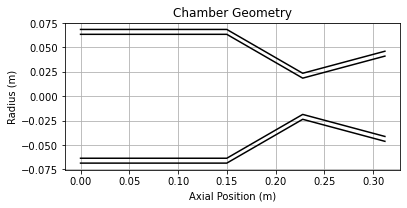

In [255]:
# define function for thickness of chamber wall th(x)

# Note: Currently Using Constant Thickness
const_thickness = 0.005 # [m]
def variable_thickness(x):
    return const_thickness
th = np.array([variable_thickness(_x) for _x in x ]) # thickness of chamber wall [m] 
    

# plot chamber geometry
fig, axs = plt.subplots()
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Chamber Geometry")
axs.set_aspect('equal')
plt.savefig(plotfolder + "enginegeometry.png", dpi=300)


### Define Injector Geometry

In [256]:
""" PLACEHOLDER CODE """
Ao = 0 # total cross sectional area of orifice [m^2]

#### (Placeholder: Coolant Channel Geometry, Nitrous and Ethane Input state)

### Discretize Engine into N Slices
To run the solver we must slice our engine into discrete section - reffered to as nodes from here on out. 

Each node has the following properties associated with it:
- $x$ - axial position of node
- $r$ - a radius of the chamber at that node
- $A$ - the cross sectional area of the chamber at that node
- $M$ - Mach number at that node of exhaust gas
- $T$ - temperature of exhaust gas at node
- $P$ - pressure of exhaust gas at node

In [257]:
# Define N
N = 100 # number of nodes

In [258]:
# Define Node Object
class Node:

    # constructor and setters
    def _init_(self):
        self.x = 0
        self.r = 0
        self.A = 0
        self.M = 0
        self.T = 0
        self.P = 0
    
    def set_x(self, x):
        self.x = x
    
    def set_r(self, r):
        self.r = r

        # implicilty calculate area from r
        self.A = np.pi * r**2
    
    def set_M(self, M):
        self.M = M

    def set_T(self, T):
        self.T = T

    def set_P(self, P):
        self.P = P

    # special methods
    def printNode(self): # for testing
        return "Node at x = {} m with r = {} m and A = {} m^2".format(self.x, self.r, self.A)


To freely discretize the geometry of the chamber we must find some functional form of expressing the geometry. Since our chamber is linear - we will just fit various straight line segments between the given geometry points.

In [259]:
# finding x positons for various pairs of points
points12x = x[:2] # points 1 and 2
points23x = x[1:3] # points 2 and 3
points34x = x[2:4] # points 3 and 4

# finding r positons for various pairs of points
points12r = r[:2] # points 1 and 2
points23r = r[1:3] # points 2 and 3
points34r = r[2:4] # points 3 and 4

# finding slopes and intercepts for various pairs of points
slope12, intercept12 = np.polyfit(points12x, points12r, 1) # points 1 and 2
slope23, intercept23 = np.polyfit(points23x, points23r, 1) # points 2 and 3
slope34, intercept34 = np.polyfit(points34x, points34r, 1) # points 3 and 4

# print all linear equations obtained
print("r = {}x + {}".format(slope12, intercept12))
print("r = {}x + {}".format(slope23, intercept23))
print("r = {}x + {}".format(slope34, intercept34))


r = -1.3887365930630215e-16x + 0.06349999999999999
r = -0.5773502691896256x + 0.15004281056560206
r = 0.26794919243112186x + -0.04241724930458759


Find node axial positons and radii.

In [260]:
x_n = np.linspace(x[0], x[-1], N) # x positions of nodes
r_n = np.zeros_like(x_n) # r positions of nodes

for i, el in enumerate(x_n):
    # find r_n
    if el <= x[1]:
        node_r_n = slope12 * el + intercept12
    elif el <= x[2]:
        node_r_n = slope23 * el + intercept23
    else:
        node_r_n = slope34 * el + intercept34

    # set r_n
    r_n[i] = node_r_n

# print results
'''
print("x_n:", x_n)
print("r_n:", r_n)
'''


'\nprint("x_n:", x_n)\nprint("r_n:", r_n)\n'

### Creating Node List
To work with each node we can store them in an array (of size $N$).

In [261]:
# create size N array of Nodes
nodes = np.empty(N, dtype=Node)

# set x and r values of each node
for i, el in enumerate(nodes):
    el = Node()
    el.set_x(x_n[i])
    el.set_r(r_n[i])
    nodes[i] = el


### Solving Exhaust Gas State at Each Slice
To solve the exhaust gas state at each slice we can use the isentropic flow equations for T and P, i.e. $T = T_0(1+\frac{k-1}{2}M^2)^{-1}$ and $p=p_0(1+\frac{k-1}{2}M^2)^{\frac{-k}{k-1}}$.<br>

But as is apparent, to do so we must first find the Mach number $M$ at each axial position of the chamber.

One potential method to do this is to use the formula for nozzle area ratio in terms of Mach number. If we look at the nozzle area ratio with the throat area $r_A = \frac{A}{A_t}$ using the fact that at the throat $M = 1$ we get the expression $r_A(M) = \frac{A}{A_t} = \frac{1}{M}(\frac{2+(k-1)M^2}{k+1})^{\frac{k+1}{2(k-1)}}$. This relates the area $A$ at any axial section to the Mach number $M$.

However, solving such an equation for Mach number $M$ given area $A$ directly is difficult, therefore we would need to use a numerical solution method (<em>such as the $root\_ scalar()$ method offered by scipy</em>).


### Finding Mach Number $M$ at Each Slice
If we try to solve for $M$ from the relation $r_A(M)$, we will get 2 solutions given a certain $A$ (<em>this is illustrated graphically in Appenidx A lower below</em>). These 2 solutions correspond accordingly to subsonic flow and supersonic flow (<em>i.e. if we just give an area $A$ and try to find the $M$ from the equation $r_A(M)$ we would get 2 Mach number $M$ values - one $M_{conv}$ if the area $A$ would be in the convergent section and one $M_{div}$ if the area would be in the divergent section </em>).

Therefore we have to separate the subsonic flow and supersonic flow cases.

In [262]:
# express r_A as a function of k and M
def A_At(M, k):
    return 1/M * ( (2 + (k-1) * M**2) / (k + 1) )**( (k+1) / (2 * (k-1) ) )

# define function to find M when flow is subsonic
def get_M_subsonic(A, A_t, kc):
    # define function to give give the numerical solver
    def func_to_solve(M): # here Mach number M is the "x" variable we want scipy.optimize.root to solve for - we want to find the coordinatate of x such that the function is zero i.e. the root
        return  A/A_t - A_At(M, kc) # we want to minimize the difference / find the root (when the difference is zero)
    
    return scipy.optimize.root_scalar(func_to_solve, bracket = [1e-5, 1], x0 = 0.5).root # the bracket is the range of values to search for the root, x0 is the initial guess

def get_M_supersonic(A, A_t, kc):
    # define function to give give the numerical solver
    def func_to_solve(M): # here Mach number M is the "x" variable we want scipy.optimize.root to solve for - we want to find the coordinatate of x such that the function is zero i.e. the root
        return  A/A_t - A_At(M, kc) # we want to minimize the difference / find the root (when the difference is zero)
    
    return scipy.optimize.root_scalar(func_to_solve, bracket = [1, 500], x0 = 1).root # the bracket is the range of values to search for the root, x0 is the initial guess

# print Mach number at exit area (supersonic) as a test
print("Mach number at exit area:", get_M_supersonic(A_e, A_t, kc))
print("Mach number at throat:", get_M_subsonic(A_t, A_t, kc))
print("Mach number at chamber entrance:", get_M_subsonic(A_c, A_t, kc))

Mach number at exit area: 2.8436539472162603
Mach number at throat: 1.0
Mach number at chamber entrance: 0.05057441153715261


In [263]:
# find Mach number at each node
for node in nodes:
    if node.x < x_c:
        node.set_M(0) # if node is in chamber, M = 0
    elif node.x < x_t:
        node.set_M(get_M_subsonic(node.A, A_t, kc)) # if node is in convergent section, M is subsonic
    else:
        node.set_M(get_M_supersonic(node.A, A_t, kc)) # if node is in divergent section, M is supersonic

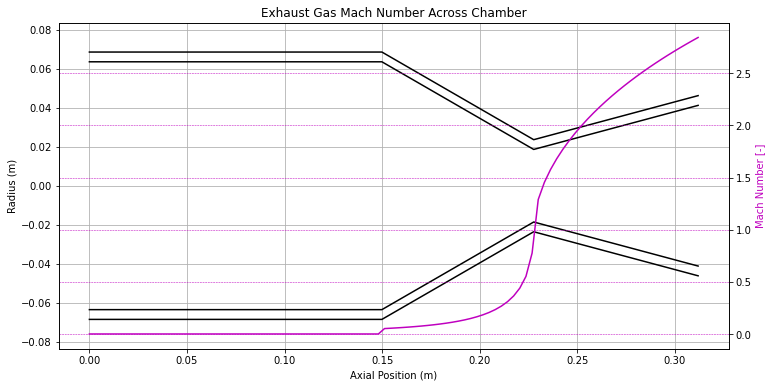

In [264]:
# plot Mach number at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Mach Number Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "m", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.M for node in nodes], color = "m")
axs2.set_ylabel("Mach Number [-]", color = "m")
plt.savefig(plotfolder + "machvsenginegeometry.png", dpi=300)
plt.show()

### Finding Temperature $T$ and Pressure $P$ of Gas at Each Node
To find $T$ and $P$ we use the Mach number at each node and the isentropic equations listed before.

In [265]:
# defining isentropic flow equations for static T and P of exhaust gas given M, kc, T0, and P0
def stat_T(M, kc, T0):
    return T0*(1 + ((kc - 1)/2) * M**2)**(-1)

def stat_P(M, kc, P0):
    return P0*(1 + ((kc - 1)/2) * M**2)**((-kc)/(kc - 1))

In [266]:
# populate nodes array with T and P values - find temperature and pressue at each node
for node in nodes:
    if node.M == 0:  # set T and P to stagnation values if node is in chamber
        node.set_T(T0)
        node.set_P(P0)
    else:
        node.set_T(stat_T(node.M, kc, T0))
        node.set_P(stat_P(node.M, kc, P0))

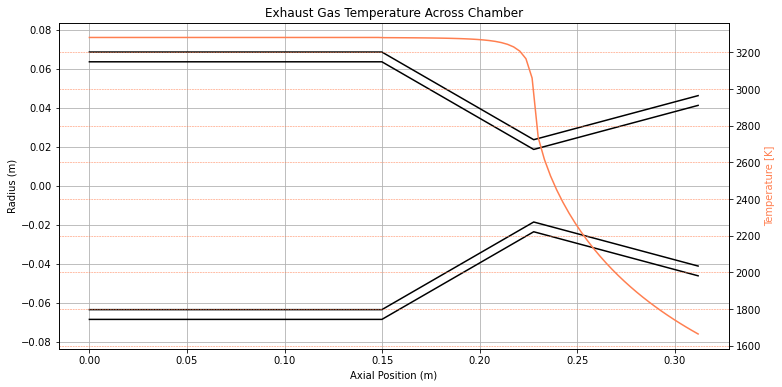

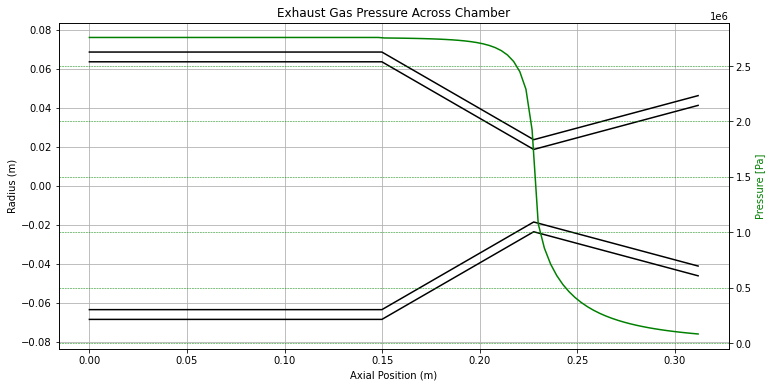

In [267]:
# plot Temperature at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Temperature Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "coral", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.T for node in nodes], color = "coral")
axs2.set_ylabel("Temperature [K]", color = "coral")
plt.savefig(plotfolder + "tempvsenginegeometry.png", dpi=300)
plt.show()

# plot Pressure at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Pressure Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "g", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.P for node in nodes], color = "g")
axs2.set_ylabel("Pressure [Pa]", color = "g")
plt.savefig(plotfolder + "presvsenginegeometry.png", dpi=300)
plt.show()

### Export Relevant Data to CSV files

In [268]:
# use pandas t export Mach number, temperature, and pressure data to csv
nodedf = pd.DataFrame({"x [m]": x_n, "r [m]": r_n, "M [-]": [node.M for node in nodes], "T [K]": [node.T for node in nodes], "P [Pa]": [node.P for node in nodes]})

# export to csv
nodedf.to_csv("enginefiles/nodedata.csv")

#### Appendix A
Illustration of the nature of equation $r_A(M) = \frac{A}{A_t} = \frac{1}{M}(\frac{2+(k-1)M^2}{k+1})^{\frac{k+1}{2(k-1)}}$.

Plotting $r_A(M)$ for different $M$ values. (<em>Horizontal line of expansion ratio $A_e/A_t$ shown</em>). From the following grap it is clear to see that for a given $A$ (<em>or more precisely $\frac{A}{A_t}$</em>) there are 2 solutions to $M$.

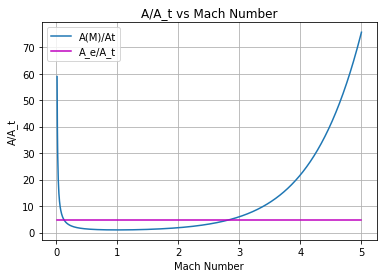

In [269]:
# plot A_At vs M varying M from 1e-2 to 5
# also plat horizontal line of A_e/A_t
fig, axs = plt.subplots()
fig.set_facecolor('white')
M = np.linspace(1e-2, 5, 1000)
axs.plot(M, A_At(M, kc), label = "A(M)/At")
axs.plot(M, A_e/A_t * np.ones(len(M)), color = "m", label = "A_e/A_t")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A/A_t")
axs.set_title("A/A_t vs Mach Number")
plt.legend()
plt.show()

The way we find particular solutions is to find the points (the Mach numbers $M$ on the horizontal axis) where the difference between our area ratio in question $\frac{A}{A_t}$ and that given by the equation $r_A(M)$ is zero (<em>i.e. find the $M$ values that solve $r_A(M) = \frac{A}{A_t}$</em>).

The plots of the <em>error</em> / <em>difference</em> function $\frac{A_e}{A_t} - r_A(M)$ for a particular area (<em> exit area $A_e$</em>) for which we numerically find a root is given below in both the subsonic and supersonic regions.

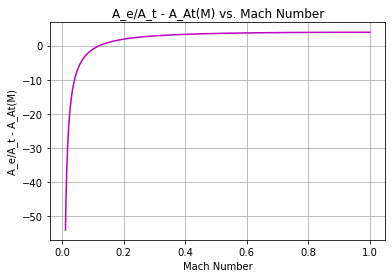

In [270]:
# plot A_e/A_t - A_At() varying M - subsonic region
fig, axs = plt.subplots()
fig.set_facecolor('white')
Mlist = np.linspace(1e-2, 1, 1000)
r_A = np.array([A_e/A_t - A_At(M, kc) for M in Mlist])
axs.plot(Mlist, r_A, color = "m")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A_e/A_t - A_At(M)")
axs.set_title("A_e/A_t - A_At(M) vs. Mach Number")
plt.show()


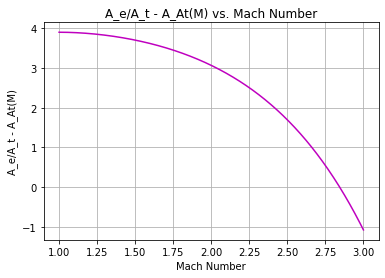

In [271]:
# plot A_e/A_t - A_At() varying M - supersonic region
fig, axs = plt.subplots()
fig.set_facecolor('white')
Mlist = np.linspace(1, 3, 1000)
r_A = np.array([A_e/A_t - A_At(M, kc) for M in Mlist])
axs.plot(Mlist, r_A, color = "m")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A_e/A_t - A_At(M)")
axs.set_title("A_e/A_t - A_At(M) vs. Mach Number")
plt.show()